# Regression task

# Preparation 

## Preparation of google drive (if required)

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch220301/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220301/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 6.2 MB/s 


In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

## サンプルデータの生成

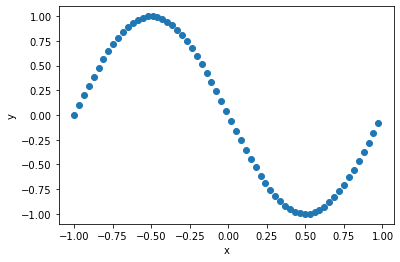

In [6]:
import matplotlib.pyplot as plt

np.random.seed(1)

input_data   = np.arange( 0, np.pi*2.0, 0.1 )
correct_data = np.sin( input_data )
n_data = len( correct_data )

# 入力を[-1.0,1.0]の範囲に
input_data = ( input_data - np.pi )/ np.pi

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter( input_data, correct_data)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

## ニューラルネットワークの定義

In [7]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;

class MSE(torch.nn.Module):
  
  class Net( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create net class")
      self.fc1 = torch.nn.Linear(1,32)
      self.fc2 = torch.nn.Linear(32,16)
      self.fc3 = torch.nn.Linear(16,1)

    def forward(self,x):
      y = torch.nn.functional.relu(self.fc1(x))
      y = torch.nn.functional.relu(self.fc2(y))
      y = self.fc3(y)
      return y

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      #output = mean_squared_error( x, t )
      loss = nn.MSELoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( MSE, self ).__init__()
    print("create mse class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    output = self.loss( self.out, self.target )
    return output

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [8]:
project = 'regr'
folder = "./regression"
json_path = folder +'/' + project +'.json'

In [9]:
! mkdir -p regression

計算グラフをJSONファイルに出力する

In [10]:
def generate_json( json_path, input, target ):
    model = MSE( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [11]:
torch.manual_seed( 1 )

input_data   = input_data.reshape(-1,1)
correct_data = correct_data.reshape(-1,1)
x_tensor = torch.from_numpy(input_data).float()
y_tensor = torch.from_numpy(correct_data).float()

batchs = 63
xb = x_tensor[0:batchs,:]
yb = y_tensor[0:batchs,:]

xb.requires_grad = True
model = generate_json( json_path, xb, yb )

create mse class
create net class
create loss class
[SAVE] ./regression/regr.json
skip: MSE/Net[net]/Linear[fc1]/weight/fc1
skip: MSE/Net[net]/Linear[fc1]/weight/fc1
skip: MSE/Net[net]/Linear[fc2]/weight/fc2
skip: MSE/Net[net]/Linear[fc2]/weight/fc2
skip: MSE/Net[net]/Linear[fc3]/weight/fc3
skip: MSE/Net[net]/Linear[fc3]/weight/fc3


In [12]:
print("xb",xb.shape)
print("yb",yb.shape)

xb torch.Size([63, 1])
yb torch.Size([63, 1])


C++コードを生成する

In [13]:
minictorch.convert_all( project, folder, model, json_path, xb, {"input_data":input_data, "target_data":correct_data}, code="all", sol="regr", epochs=2000, batch=9, shuffle=1,shape=0 )

[JSON] ./regression/regr.json
param: xin  - str loop  7  /  7
{'name': 'MSE/Net[net]/Linear[fc1]/weight/weight.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
param: fc1_weight  - str loop  3  /  3
{'name': 'MSE/Net[net]/Linear[fc1]/bias/bias.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
param: fc1_bias  - str loop  3  /  3
{'name': 'MSE/Net[net]/Linear[fc2]/weight/weight.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
param: fc2_weight  - str loop  63  /  63
{'name': 'MSE/Net[net]/Linear[fc2]/bias/bias.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
param: fc2_bias  - str loop  1  /  1
{'name': 'MSE/Net[net]/Linear[fc3]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [11], 'sorted_id': 9}
param: fc3_weight  - str loop  1  /  1
{'name': 'MSE/Net[net]/Linear[fc3]/bias

In [14]:
# check code
with torch.set_grad_enabled(True):
  model.train()
  yy = model( xb )
  print("output",yy)
  print("out",model.out.shape)
  yy.backward()
  #print("input",xb.grad)

output tensor(0.5289, grad_fn=<MseLossBackward0>)
out torch.Size([63, 1])


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

# コンパイル

In [15]:
C_SRC = './regression/regr.cpp ./regression/regr_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './regression/regr'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./regression/regr.cpp ./regression/regr_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./regression/regr


In [16]:
!./regression/regr

### forward computation ...
 0.528857
### backward computation ...
input_grad{{ 0.000114},
 { 0.00021 },
 { 0.000305},
 {-0.000047},
 {-0.000057},
 {-0.000067},
 {-0.000077},
 {-0.000086},
 {-0.000094},
 {-0.000101},
 {-0.000108},
 {-0.000731},
 {-0.00076 },
 {-0.000783},
 { 0.000304},
 { 0.000307},
 { 0.000308},
 { 0.000336},
 { 0.000331},
 {-0.000714},
 {-0.000689},
 {-0.000657},
 {-0.001141},
 {-0.001062},
 {-0.000946},
 {-0.000853},
 {-0.000752},
 {-0.00026 },
 {-0.000441},
 {-0.000346},
 {-0.000248},
 {-0.000148},
 {-0.000049},
 { 0.00005 },
 { 0.000148},
 { 0.000243},
 { 0.000335},
 { 0.000422},
 { 0.000504},
 { 0.00058 },
 { 0.000649},
 { 0.00114 },
 { 0.001227},
 { 0.0013  },
 { 0.001245},
 { 0.001285},
 { 0.00131 },
 { 0.001321},
 { 0.001318},
 { 0.0013  },
 { 0.001268},
 { 0.001222},
 { 0.001163},
 { 0.001091},
 { 0.001007},
 { 0.000451},
 { 0.000398},
 { 0.000341},
 { 0.000279},
 { 0.000215},
 { 0.000147},
 {-0.000025},
 {-0.000002}}


# Python 学習コード

学習ループの実行(python版)

In [20]:
torch.manual_seed( 1 )

epochs = 2000

model = MSE( y_tensor )
model.train()

lr = 0.01
opt = torch.optim.SGD(model.parameters(), lr)
#opt = torch.optim.Adam(net.parameters(), lr )

x_tensor.requires_grad = True

batch_size = 9
n_batch = len(x_tensor) // batch_size  # 1エポックあたりのバッチ数
print("batch ",n_batch,batch_size)

epoch_loss = []
for i in range(epochs):

    # -- 学習 -- 
    """
    opt.zero_grad()
    loss = net( x_tensor )
    total_loss = loss;
    loss.backward()
    opt.step()
    """
    # ミニバッチ
    index_random = np.arange( n_data )
    np.random.shuffle( index_random )  # インデックスをシャッフルする

    total_loss = 0.0
    for idx in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ idx*batch_size : (idx+1)*batch_size ]
        x = x_tensor[ mb_index,:]
        t = y_tensor[ mb_index,:]
        
        # 順伝播と逆伝播
        model.target = t
        loss = model( x )
        total_loss += float(loss);
        #print("loss",loss)

        opt.zero_grad()
        loss.backward()
        opt.step()
    #"""
    # -- 誤差 --
    print("epoch: {} loss: {}".format(i, total_loss))
    epoch_loss.append( total_loss )

#model.target = y_tensor
#output = model.net( x_tensor )

create mse class
create net class
create loss class
batch  7 9
epoch: 0 loss: 3.6213527619838715
epoch: 1 loss: 3.3853610455989838
epoch: 2 loss: 3.192731887102127
epoch: 3 loss: 3.0357872247695923
epoch: 4 loss: 2.889925792813301
epoch: 5 loss: 2.7597695887088776
epoch: 6 loss: 2.6006080508232117
epoch: 7 loss: 2.469493567943573
epoch: 8 loss: 2.3649493157863617
epoch: 9 loss: 2.2172150760889053
epoch: 10 loss: 2.1131733506917953
epoch: 11 loss: 2.0044846683740616
epoch: 12 loss: 1.8987350314855576
epoch: 13 loss: 1.8002862930297852
epoch: 14 loss: 1.7186075150966644
epoch: 15 loss: 1.6291817277669907
epoch: 16 loss: 1.55691559612751
epoch: 17 loss: 1.4973912239074707
epoch: 18 loss: 1.4268264025449753
epoch: 19 loss: 1.379214569926262
epoch: 20 loss: 1.3278840631246567
epoch: 21 loss: 1.2839274480938911
epoch: 22 loss: 1.2526648342609406
epoch: 23 loss: 1.2342592999339104
epoch: 24 loss: 1.2039298191666603
epoch: 25 loss: 1.1771783083677292
epoch: 26 loss: 1.1586022078990936
epoch: 2

In [21]:
model.target = y_tensor
output = model.net( x_tensor )
print( x_tensor )

tensor([[-1.0000],
        [-0.9682],
        [-0.9363],
        [-0.9045],
        [-0.8727],
        [-0.8408],
        [-0.8090],
        [-0.7772],
        [-0.7454],
        [-0.7135],
        [-0.6817],
        [-0.6499],
        [-0.6180],
        [-0.5862],
        [-0.5544],
        [-0.5225],
        [-0.4907],
        [-0.4589],
        [-0.4270],
        [-0.3952],
        [-0.3634],
        [-0.3315],
        [-0.2997],
        [-0.2679],
        [-0.2361],
        [-0.2042],
        [-0.1724],
        [-0.1406],
        [-0.1087],
        [-0.0769],
        [-0.0451],
        [-0.0132],
        [ 0.0186],
        [ 0.0504],
        [ 0.0823],
        [ 0.1141],
        [ 0.1459],
        [ 0.1777],
        [ 0.2096],
        [ 0.2414],
        [ 0.2732],
        [ 0.3051],
        [ 0.3369],
        [ 0.3687],
        [ 0.4006],
        [ 0.4324],
        [ 0.4642],
        [ 0.4961],
        [ 0.5279],
        [ 0.5597],
        [ 0.5915],
        [ 0.6234],
        [ 0.

収束状況グラフを描画する

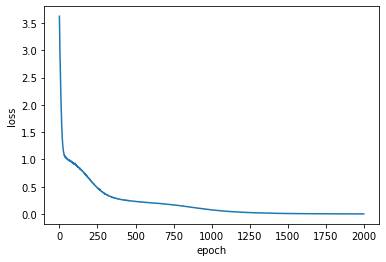

In [22]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

評価データを描画する

(63, 1)


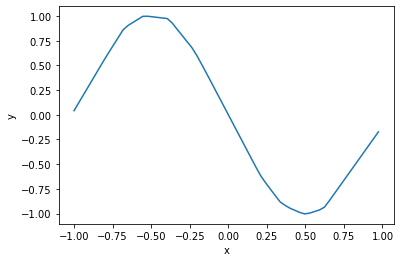

In [23]:
o = output.to('cpu').detach().numpy().copy()
print(o.shape)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(input_data, o)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

# C++ 学習コード

学習用C++コードをコンパイル、リンクする

In [24]:
C_SRC = './regression/regr_train.cpp ./regression/regr_param.cpp ./regression/regr.cpp ./regression/regr_data.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './regression/regr_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./regression/regr_train.cpp ./regression/regr_param.cpp ./regression/regr.cpp ./regression/regr_data.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./regression/regr_train


In [25]:
!./regression/regr_train

epoch_num : 2000
batch  number  : 7,9
learning ratio : 0.01
total_loss : epoch 0 - loss 3.60639
epoch 0 - loss 0.495047
total_loss : epoch 1 - loss 3.4095
epoch 1 - loss 0.466364
total_loss : epoch 2 - loss 3.20278
epoch 2 - loss 0.442078
total_loss : epoch 3 - loss 3.03924
epoch 3 - loss 0.419438
total_loss : epoch 4 - loss 2.88665
epoch 4 - loss 0.398929
total_loss : epoch 5 - loss 2.7467
epoch 5 - loss 0.378469
total_loss : epoch 6 - loss 2.59725
epoch 6 - loss 0.358806
total_loss : epoch 7 - loss 2.474
epoch 7 - loss 0.340444
total_loss : epoch 8 - loss 2.34285
epoch 8 - loss 0.323027
total_loss : epoch 9 - loss 2.21666
epoch 9 - loss 0.306386
total_loss : epoch 10 - loss 2.10939
epoch 10 - loss 0.290326
total_loss : epoch 11 - loss 1.99065
epoch 11 - loss 0.275254
total_loss : epoch 12 - loss 1.88989
epoch 12 - loss 0.261175
total_loss : epoch 13 - loss 1.81466
epoch 13 - loss 0.24816
total_loss : epoch 14 - loss 1.70425
epoch 14 - loss 0.235817
total_loss : epoch 15 - loss 1.6266

In [26]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

epoch_loss = []

datalist = f.readlines()
for data in datalist:
  #print(data)
  epoch_loss.append( float(data) )

f.close()

print("[OUT]",path)
print("epoch =", len(epoch_loss))
print( epoch_loss)

path = folder + '/' + project + '.pred'
f2 = open( path, 'r')

x_new = []
y_pred = []
k = 0
datalist = f2.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  if k == 0:
    print(ds)
    n1 = int(ds[0])
    n2 = int(ds[1])
  else:
    x_new.append( input_data[k-1,0] )
    y_pred.append( float(ds[0]) )
  k = k+1

f2.close()

print("pred =", len(x_new))
print( x_new )
print( y_pred )


[OUT] ./regression/regr.out
epoch = 2000
[0.495047, 0.466364, 0.442078, 0.419438, 0.398929, 0.378469, 0.358806, 0.340444, 0.323027, 0.306386, 0.290326, 0.275254, 0.261175, 0.24816, 0.235817, 0.224731, 0.214914, 0.206033, 0.198126, 0.191114, 0.185037, 0.179531, 0.174973, 0.170839, 0.16748, 0.164387, 0.161766, 0.159423, 0.157616, 0.155837, 0.154367, 0.153115, 0.151903, 0.15087, 0.150179, 0.149234, 0.148569, 0.147879, 0.147266, 0.146809, 0.146382, 0.145828, 0.14548, 0.145, 0.144723, 0.1443, 0.143928, 0.143679, 0.143299, 0.142955, 0.14265, 0.142354, 0.14209, 0.141816, 0.141552, 0.141328, 0.141043, 0.140781, 0.140587, 0.140272, 0.14, 0.13975, 0.139486, 0.139215, 0.138964, 0.138783, 0.138517, 0.138193, 0.137924, 0.1377, 0.137458, 0.137262, 0.137082, 0.136623, 0.136366, 0.136095, 0.135828, 0.135656, 0.135308, 0.135148, 0.134769, 0.134488, 0.134214, 0.133971, 0.133675, 0.133401, 0.133114, 0.132829, 0.13254, 0.132257, 0.131999, 0.131734, 0.131413, 0.131108, 0.130821, 0.130555, 0.130234, 0.12995

収束状況グラフを描画する

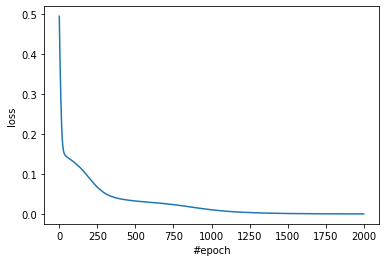

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

評価データを描画する

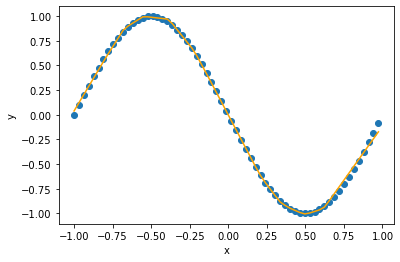

In [28]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(input_data,correct_data )
ax.plot( x_new, y_pred, c='orange')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()